In [2]:
%matplotlib notebook
from dual_quaternions import *
from spatialmath.base import *
import numpy as np
from pyquaternion import *
from spatialmath import *
import roboticstoolbox as rtb
from math import pi
from robolink import *
import time 

import numpy as np
from numpy import linalg


import cmath
import math
from math import cos as cos
from math import sin as sin
from math import atan2 as atan2
from math import acos as acos
from math import asin as asin
from math import sqrt as sqrt
from math import pi as pi

from spatialmath.base import *
from spatialmath import *
import roboticstoolbox as rtb

global mat
mat=np.matrix


# ****** Coefficients ******


global d1, a2, a3, a7, d4, d5, d6
d1 =  0.1273
a2 = -0.612
a3 = -0.5723
a7 = 0.075
d4 =  0.163941
d5 =  0.1157
d6 =  0.0922

global d, a, alph

#d = mat([0.089159, 0, 0, 0.10915, 0.09465, 0.0823]) ur5
d = mat([0.1273, 0, 0, 0.163941, 0.1157, 0.0922])#ur10 mm
# a =mat([0 ,-0.425 ,-0.39225 ,0 ,0 ,0]) ur5
a =mat([0 ,-0.612 ,-0.5723 ,0 ,0 ,0])#ur10 mm
#alph = mat([math.pi/2, 0, 0, math.pi/2, -math.pi/2, 0 ])  #ur5
alph = mat([pi/2, 0, 0, pi/2, -pi/2, 0 ]) # ur10


from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt



init_config = [0, 0, -pi/6, pi/6, pi/2, 0]#[0,-pi/6,pi/6,0,pi/2,0]
con_config =  [-0.1, (23/180)*pi, -pi/2, pi/2.7, pi/2, 0]
round_config = [-pi/2, (23/180)*pi, -pi/2, pi/2.7, pi/2, 0]
end_config = [-pi/2, (13/180)*pi, -pi/6, pi/10, pi/2, 0]

RDK = Robolink()                    # establish a link with the simulator
robot = RDK.Item('UR10e') 
np.degrees(init_config)

robot.MoveJ([0, 0, -30, 30, 90, 0])

def AH( n,th,c  ):

  T_a = mat(np.identity(4), copy=False)
  T_a[0,3] = a[0,n-1]
  T_d = mat(np.identity(4), copy=False)
  T_d[2,3] = d[0,n-1]

  Rzt = mat([[cos(th[n-1,c]), -sin(th[n-1,c]), 0 ,0],
             [sin(th[n-1,c]),  cos(th[n-1,c]), 0, 0],
             [0,               0,              1, 0],
             [0,               0,              0, 1]],copy=False)
      

  Rxa = mat([[1, 0,                 0,                  0],
             [0, cos(alph[0,n-1]), -sin(alph[0,n-1]),   0],
             [0, sin(alph[0,n-1]),  cos(alph[0,n-1]),   0],
             [0, 0,                 0,                  1]],copy=False)

  A_i = T_d * Rzt * T_a * Rxa
   

  return A_i

def invKine(desired_pos):# T60
  th = mat(np.zeros((6, 8)))
  P_05 = (desired_pos * mat([0,0, -d6, 1]).T-mat([0,0,0,1 ]).T)
  
  # **** theta1 ****
  
  psi = atan2(P_05[2-1,0], P_05[1-1,0])
  phi = acos(d4 /sqrt(P_05[2-1,0]*P_05[2-1,0] + P_05[1-1,0]*P_05[1-1,0]))
  #The two solutions for theta1 correspond to the shoulder
  #being either left or right
  th[0, 0:4] = pi/2 + psi + phi
  th[0, 4:8] = pi/2 + psi - phi
  th = th.real
  
  # **** theta5 ****
  
  cl = [0, 4]# wrist up or down
  for i in range(0,len(cl)):
          c = cl[i]
          T_10 = linalg.inv(AH(1,th,c))
          T_16 = T_10 * desired_pos
          th[4, c:c+2] = + acos((T_16[2,3]-d4)/d6);
          th[4, c+2:c+4] = - acos((T_16[2,3]-d4)/d6);

  th = th.real
  
  # **** theta6 ****
  # theta6 is not well-defined when sin(theta5) = 0 or when T16(1,3), T16(2,3) = 0.

  cl = [0, 2, 4, 6]
  for i in range(0,len(cl)):
          c = cl[i]
          T_10 = linalg.inv(AH(1,th,c))
          T_16 = linalg.inv( T_10 * desired_pos )
          th[5, c:c+2] = atan2((-T_16[1,2]/sin(th[4, c])),(T_16[0,2]/sin(th[4, c])))
  
  th = th.real

  # **** theta3 ****
  cl = [0, 2, 4, 6]
  for i in range(0,len(cl)):
          c = cl[i]
          T_10 = linalg.inv(AH(1,th,c))
          T_65 = AH( 6,th,c)
          T_54 = AH( 5,th,c)
          T_14 = ( T_10 * desired_pos) * linalg.inv(T_54 * T_65)
          P_13 = T_14 * mat([0, -d4, 0, 1]).T - mat([0,0,0,1]).T
          t3 = cmath.acos((linalg.norm(P_13)**2 - a2**2 - a3**2 )/(2 * a2 * a3)) # norm ?
          th[2, c] = t3.real
          th[2, c+1] = -t3.real

  # **** theta2 and theta 4 ****

  cl = [0, 1, 2, 3, 4, 5, 6, 7]
  for i in range(0,len(cl)):
          c = cl[i]
          T_10 = linalg.inv(AH( 1,th,c ))
          T_65 = linalg.inv(AH( 6,th,c))
          T_54 = linalg.inv(AH( 5,th,c))
          T_14 = (T_10 * desired_pos) * T_65 * T_54
          P_13 = T_14 * mat([0, -d4, 0, 1]).T - mat([0,0,0,1]).T
      
          # theta 2
          th[1, c] = -atan2(P_13[1], -P_13[0]) + asin(a3* sin(th[2,c])/linalg.norm(P_13))
          # theta 4
          T_32 = linalg.inv(AH( 3,th,c))
          T_21 = linalg.inv(AH( 2,th,c))
          T_34 = T_32 * T_21 * T_14
          th[3, c] = atan2(T_34[1,0], T_34[0,0])
  th = th.real

  return th

def dh_matrix(theta_z,d_z,a_x,alpha_x):
    return trotz(theta_z)@transl(0.0, 0.0, d_z)@transl(a_x, 0.0, 0.0)@trotx(alpha_x)

def UR10_matrix(M):
    
    HTM_1=dh_matrix(M[0],0.1273,0,pi/2)
    HTM_2=dh_matrix(M[1],0,-0.612,0)
    HTM_3=dh_matrix(M[2],0,-0.5723,0)
    HTM_4=dh_matrix(M[3],0.1639 ,0,pi/2)
    HTM_5=dh_matrix(M[4],0.1157,0,-pi/2)
    HTM_6=dh_matrix(M[5],0.0922,0,0)
    return HTM_1@HTM_2@HTM_3@HTM_4@HTM_5@HTM_6

In [3]:
robot4 = rtb.models.DH.UR10()
robot4

DHRobot: UR10 (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┏━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃θⱼ  ┃   dⱼ   ┃   aⱼ    ┃   ⍺ⱼ   ┃
┣━━━━╋━━━━━━━━╋━━━━━━━━━╋━━━━━━━━┫
┃ q1 ┃ 0.1273 ┃       0 ┃  90.0° ┃
┃ q2 ┃      0 ┃  -0.612 ┃   0.0° ┃
┃ q3 ┃      0 ┃ -0.5723 ┃   0.0° ┃
┃ q4 ┃ 0.1639 ┃       0 ┃  90.0° ┃
┃ q5 ┃ 0.1157 ┃       0 ┃ -90.0° ┃
┃ q6 ┃ 0.0922 ┃       0 ┃   0.0° ┃
┗━━━━┻━━━━━━━━┻━━━━━━━━━┻━━━━━━━━┛

┌─────┬───────┬─────┬─────┬─────┬──────┬─────┐
│name │ q0    │ q1  │ q2  │ q3  │ q4   │ q5  │
├─────┼───────┼─────┼─────┼─────┼──────┼─────┤
│  qz │  0°   │  0° │  0° │  0° │  0°  │  0° │
│  qr │  180° │  0° │  0° │  0° │  90° │  0° │
└─────┴───────┴─────┴─────┴─────┴──────┴─────┘

# ScLERP

In [5]:
%matplotlib notebook
from dual_quaternions import *
from spatialmath.base import *
import numpy as np
from pyquaternion import *
from spatialmath import *
import roboticstoolbox as rtb
from math import pi
import matplotlib.pyplot as plt


from dual_quaternions import *
def ScLERP(init_config, end_config):
    end_HTM=UR10_matrix(end_config) #matriz final

    current_config=init_config
    init_HTM=UR10_matrix(init_config)

    n=0
    
    theta1=[]
    theta2=[]
    theta3=[]
    theta4=[]
    theta5=[]
    theta6=[]
    
    while(n<=50):
        tao=(n/50)
        print(tao)
        
        init_DQ=DualQuaternion.from_homogeneous_matrix(init_HTM)
        f_DQ=DualQuaternion.from_homogeneous_matrix(end_HTM)
        current_DQ = init_DQ.__mul__((init_DQ.quaternion_conjugate().__mul__(f_DQ)).pow(tao))
        current_HT = current_DQ.homogeneous_matrix()
        print(current_HT)
        
        
        conf8_= invKine(current_HT) #8 solutions for the same HTM
        current_conf=np.array(conf8_[:,1]) #One solution chosen
        cconf_list=[current_conf[0][0] % -pi, current_conf[1][0],current_conf[2][0],current_conf[3][0],current_conf[4][0],current_conf[5][0]] 
        deg_list = np.degrees(cconf_list) #current config in degs
        print(cconf_list)

        SE3(current_HT).plot()

        theta1.append(cconf_list[0])
        theta2.append(cconf_list[1])
        theta3.append(cconf_list[2])
        theta4.append(cconf_list[3])
        theta5.append(cconf_list[4])
        theta6.append(cconf_list[5])
        
        

        robot.MoveJ([deg_list[0],deg_list[1],deg_list[2],deg_list[3],deg_list[4],deg_list[5]])   # move the robot to the target
        import time
        time.sleep(0.1)
        
        


        n=n+1
    
    
    return theta1, theta2,theta3, theta4,theta5, theta6
        #ax.plot(deg_list[1],n,'-',linewidth=2,color='r',label='3,4')

0.0
[[ 1.66533454e-16  2.77555756e-17 -1.00000000e+00 -1.19982634e+00]
 [-1.00000000e+00  1.66533454e-16 -1.66533454e-16 -1.63900000e-01]
 [ 1.66533454e-16  1.00000000e+00  5.55111512e-17  2.97750000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-3.701619478446716e-05, 1.717185274729971e-05, -0.5236371514052977, 0.5236199795525502, 1.570759310600109, 1.0530316850604321e-16]


<IPython.core.display.Javascript object>


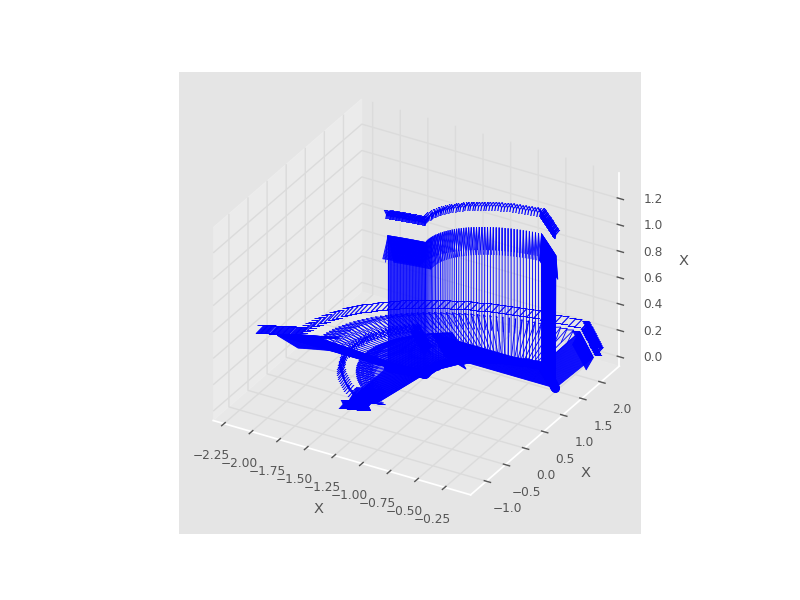

0.02
[[-1.99999336e-03  1.16252409e-04 -9.99997993e-01 -1.19375772e+00]
 [-9.99998000e-01 -5.93401821e-06  1.99999268e-03 -1.61826402e-01]
 [-5.70150234e-06  9.99999993e-01  1.16264044e-04  2.97808516e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.0017524713308849638, 0.0172523290514226, -0.5623852026061071, 0.5450166095064263, 1.5710438494902081, -5.730280367584057e-06]
0.04
[[-3.99997936e-03  2.32492716e-04 -9.99991973e-01 -1.18768497e+00]
 [-9.99992000e-01 -1.21005285e-05  3.99997666e-03 -1.59764945e-01]
 [-1.11704659e-05  9.99999973e-01  2.32539258e-04  2.97866339e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.0034762956004754653, 0.033287708102190894, -0.5986906476030485, 0.5651704002091423, 1.5713200186136462, -1.1292245142413997e-05]
0.06
[[-5.99994999e-03  3.48720454e-04 -9.99981939e-01 -1.18160809e+00]
 [-9.99982000e-01 -1.84995061e-05  5.99994391e-03 -1.57715639e-01]
 [-1.64068688e-05  9.99999939e-01  3.48825173e-04 

0.44
[[-4.39857956e-02  2.55403937e-03 -9.99028892e-01 -1.06539769e+00]
 [-9.99032154e-01 -1.84209130e-04  4.39854683e-02 -1.21097923e-01]
 [-7.16896252e-05  9.99996721e-01  2.55967004e-03  2.98876275e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.03996549684580164, 0.24242489480131862, -1.1030723803946594, 0.8580877919252704, 1.5748306248806565, -8.201642196385831e-05]
0.46
[[-4.59837733e-02  2.66991786e-03 -9.98938619e-01 -1.05924360e+00]
 [-9.98942184e-01 -1.95250821e-04  4.59834156e-02 -1.19293274e-01]
 [-7.22716424e-05  9.99996417e-01  2.67607195e-03  2.98919406e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.0419053127594462, 0.24993388150478618, -1.1226991989482886, 0.8700892198693368, 1.5748908003577695, -8.322910758248578e-05]
0.48
[[-4.79815672e-02  2.78577399e-03 -9.98844337e-01 -1.05308592e+00]
 [-9.98848219e-01 -2.06524243e-04  4.79811777e-02 -1.17500936e-01]
 [-7.26208537e-05  9.99996098e-01  2.79247475e-03  2.989

0.86
[[-8.58940542e-02  4.98217595e-03 -9.96291819e-01 -9.35438530e-01]
 [-9.96304276e-01 -4.64682658e-04  8.58928044e-02 -8.57950442e-02]
 [-3.50264669e-05  9.99987481e-01  5.00367668e-03  2.99633298e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.0837353590921357, 0.370175828587072, -1.4661145037348322, 1.0909349647609694, 1.573060788560558, -4.635770110138689e-05]
0.88
[[-8.78864878e-02  5.09748754e-03 -9.96117453e-01 -9.29214017e-01]
 [-9.96130496e-01 -4.80579988e-04  8.78851792e-02 -8.42503871e-02]
 [-3.07205077e-05  9.99986892e-01  5.11999928e-03  2.99661521e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.08600442592267932, 0.3749464969985065, -1.4814532048604678, 1.1013866760202182, 1.5727917400787497, -4.0937572382088786e-05]
0.9
[[-8.98785694e-02  5.21276704e-03 -9.95939089e-01 -9.22986423e-01]
 [-9.95952731e-01 -4.96707905e-04  8.98772007e-02 -8.27181822e-02]
 [-2.61819093e-05  9.99986290e-01  5.23631297e-03  2.9968902

0.26
[[-4.63912872e-01  5.15381669e-03 -8.85865839e-01 -8.55465119e-01]
 [-8.85880831e-01 -2.69892046e-03  4.63905022e-01  2.62971353e-01]
 [ 2.22044605e-16  9.99983077e-01  5.81773135e-03  2.99815830e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.4824590996513862, 0.4014311756527094, -1.5708154989396128, 1.1635665591057072, 1.5707442729911079, 3.0284017186476766e-07]
0.28
[[-4.89767423e-01  5.07220726e-03 -8.71838370e-01 -8.47360600e-01]
 [-8.71853125e-01 -2.84933529e-03  4.89759135e-01  2.88018257e-01]
 [ 1.66533454e-16  9.99983077e-01  5.81773135e-03  2.99815830e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.5118750261872842, 0.40143117565270947, -1.5708154989396128, 1.163566559105707, 1.5707442729911087, 3.0284017180926323e-07]
0.3
[[-5.15198210e-01  4.98620919e-03 -8.57056557e-01 -8.38522915e-01]
 [-8.57071061e-01 -2.99728478e-03  5.15189492e-01  3.12815958e-01]
 [ 2.22044605e-16  9.99983077e-01  5.81773135e-03  2.9981583

0.68
[[-8.91271536e-01  2.63816669e-03 -4.53462335e-01 -5.45058619e-01]
 [-4.53470009e-01 -5.18517836e-03  8.91256453e-01  7.09849001e-01]
 [ 2.22044605e-16  9.99983077e-01  5.81773135e-03  2.99815830e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.1001935569052428, 0.40143117565270947, -1.5708154989396124, 1.1635665591057063, 1.5707442729911094, 3.028401718644606e-07]
0.7
[[-9.04223273e-01  2.48452054e-03 -4.27052806e-01 -5.23944963e-01]
 [-4.27060033e-01 -5.26052809e-03  9.04207971e-01  7.25573000e-01]
 [ 1.94289029e-16  9.99983077e-01  5.81773135e-03  2.99815830e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.1296094834411399, 0.40143117565270886, -1.5708154989396101, 1.163566559105705, 1.5707442729911165, 3.0284017183250714e-07]
0.72
[[-9.16392646e-01  2.32872471e-03 -4.00273776e-01 -5.02377971e-01]
 [-4.00280550e-01 -5.33132623e-03  9.16377138e-01  7.40669209e-01]
 [ 1.66533454e-16  9.99983077e-01  5.81773135e-03  2.9981583

0.08
[[-1.00000000e+00  1.22706440e-16 -1.22221961e-16 -1.63900000e-01]
 [-1.22706440e-16 -3.95606932e-03  9.99992175e-01  9.08372825e-01]
 [ 1.22221961e-16  9.99992175e-01  3.95606932e-03  2.79307418e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5708465614625151, 0.41196704961262365, -1.5211264465415495, 1.1052033172860802, 1.5707460925203802, 1.9873182753094036e-07]
0.1
[[-1.00000000e+00  1.22678048e-16 -1.22250566e-16 -1.63900000e-01]
 [-1.22678048e-16 -3.49065142e-03  9.99993908e-01  9.15501075e-01]
 [ 1.22250566e-16  9.99993908e-01  3.49065142e-03  2.74172016e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.570846126529803, 0.4140857757595107, -1.508155656408284, 1.0905792221404562, 1.5707465273633832, 1.738335153348848e-07]
0.12
[[-1.00000000e+00  1.22649642e-16 -1.22279158e-16 -1.63900000e-01]
 [-1.22649642e-16 -3.02523276e-03  9.99995424e-01  9.22626934e-01]
 [ 1.22279158e-16  9.99995424e-01  3.02523276e-03  2.69033298e

0.5
[[-1.00000000e+00  1.22107410e-16 -1.22819877e-16 -1.63900000e-01]
 [-1.22107410e-16  5.81773135e-03  9.99983077e-01  1.05756194e+00]
 [ 1.22819877e-16  9.99983077e-01 -5.81773135e-03  1.70768887e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5708387979965348, 0.4111797141980529, -1.1956812674148443, 0.7903193173953529, 1.5707538563120038, -2.4708604154387314e-07]
0.52
[[-1.00000000e+00  1.22078740e-16 -1.22848203e-16 -1.63900000e-01]
 [-1.22078740e-16  6.28314397e-03  9.99980261e-01  1.06463966e+00]
 [ 1.22848203e-16  9.99980261e-01 -6.28314397e-03  1.65564062e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5708384888649736, 0.4085869087568646, -1.1768807205292977, 0.7745769970851971, 1.5707541655570603, -2.6491035627712623e-07]
0.54
[[-1.00000000e+00  1.22050056e-16 -1.22876515e-16 -1.63900000e-01]
 [-1.22050056e-16  6.74855522e-03  9.99977228e-01  1.07171495e+00]
 [ 1.22876515e-16  9.99977228e-01 -6.74855522e-03  1.60355

0.92
[[-1.00000000e+00  1.21502565e-16 -1.23411909e-16 -1.63900000e-01]
 [-1.21502565e-16  1.55909763e-02  9.99878453e-01  1.20568311e+00]
 [ 1.23411909e-16  9.99878453e-01 -1.55909763e-02  6.07774134e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5708331479179751, 0.28315331225105694, -0.6807266687931522, 0.41316496453714596, 1.5707595101472982, -5.740772566032993e-07]
0.94
[[-1.00000000e+00  1.21473619e-16 -1.23439954e-16 -1.63900000e-01]
 [-1.21473619e-16  1.60563391e-02  9.99871089e-01  1.21270962e+00]
 [ 1.23439954e-16  9.99871089e-01 -1.60563391e-02  5.55036613e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5708329169983895, 0.27096302081578083, -0.6451349428414677, 0.39022895115478207, 1.5707597413082974, -5.875047164980328e-07]
0.96
[[-1.00000000e+00  1.21444660e-16 -1.23467984e-16 -1.63900000e-01]
 [-1.21444660e-16  1.65216985e-02  9.99863507e-01  1.21973367e+00]
 [ 1.23467984e-16  9.99863507e-01 -1.65216985e-02  5.02

In [28]:
from dual_quaternions import *
theta1, theta2,theta3, theta4,theta5, theta6=ScLERP(init_config, con_config)
theta11, theta21,theta31, theta41,theta51, theta61=ScLERP(con_config, round_config)
theta12, theta22,theta32, theta42,theta52, theta62=ScLERP(round_config, end_config)


In [29]:
theta1 = np.hstack((np.hstack((np.array(theta1),np.array(theta11))),theta12))
theta2 = np.hstack((np.hstack((np.array(theta2),np.array(theta21))),theta22))
theta3 = np.hstack((np.hstack((np.array(theta3),np.array(theta31))),theta32))
theta4 = np.hstack((np.hstack((np.array(theta4),np.array(theta41))),theta42))
theta5 = np.hstack((np.hstack((np.array(theta5),np.array(theta51))),theta52))
theta6 = np.hstack((np.hstack((np.array(theta6),np.array(theta61))),theta62))

<IPython.core.display.Javascript object>


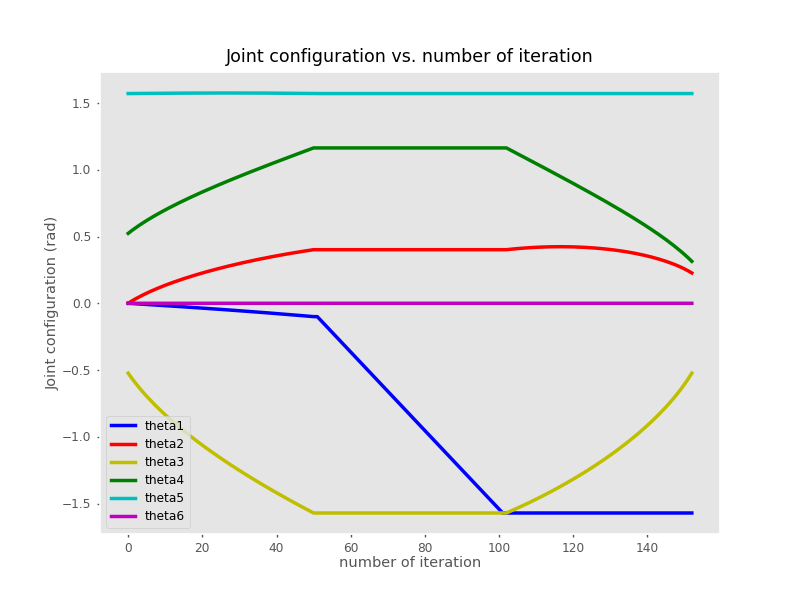

In [32]:
fig = plt.figure("With turning machine")
ax = plt.subplot(111)
ax.plot(list(range(153)),theta1,'-',linewidth=2,color='b',label='theta1')
ax.plot(list(range(153)),theta2,'-',linewidth=2,color='r',label='theta2')
ax.plot(list(range(153)),theta3,'-',linewidth=2,color='y',label='theta3')
ax.plot(list(range(153)),theta4,'-',linewidth=2,color='g',label='theta4')
ax.plot(list(range(153)),theta5,'-',linewidth=2,color='c',label='theta5')
ax.plot(list(range(153)),theta6,'-',linewidth=2,color='m',label='theta6')

plt.ylabel('Joint configuration (rad)')
plt.xlabel('number of iteration')
plt.title("Joint configuration vs. number of iteration")
ax.legend()
plt.grid()


0.0
[[ 1.66533454e-16  2.77555756e-17 -1.00000000e+00 -1.19982634e+00]
 [-1.00000000e+00  1.66533454e-16 -1.66533454e-16 -1.63900000e-01]
 [ 1.66533454e-16  1.00000000e+00  5.55111512e-17  2.97750000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-3.701619478446716e-05, 1.717185274729971e-05, -0.5236371514052977, 0.5236199795525502, 1.570759310600109, 1.0530316850604321e-16]


<IPython.core.display.Javascript object>


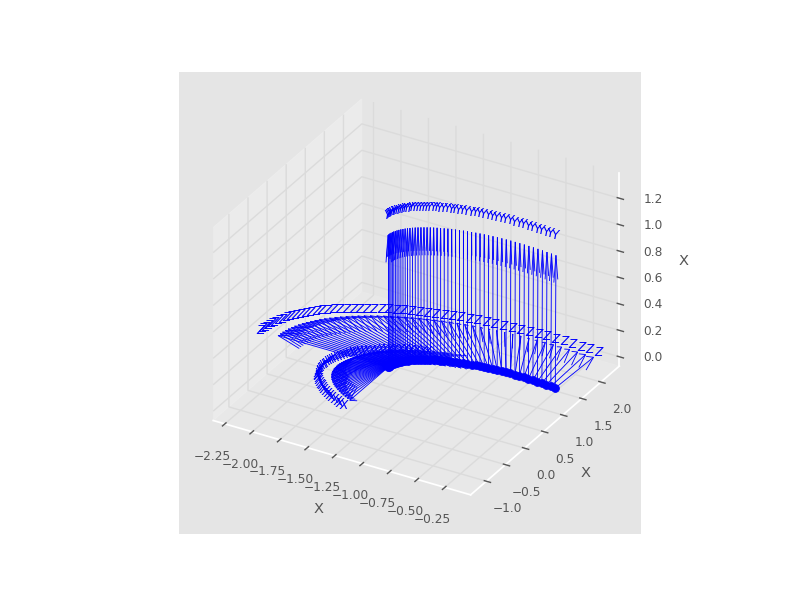

0.02
[[-3.14099269e-02 -2.69804008e-04 -9.99506550e-01 -1.20495033e+00]
 [-9.99506550e-01  2.78415896e-04  3.14098518e-02 -1.25564687e-01]
 [ 2.69804008e-04  9.99999925e-01 -2.78415896e-04  2.92723179e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.031948292250502774, 0.006629206284278377, -0.5283241429368803, 0.5219733525915102, 1.5702630545602625, 0.0002696555497885916]
0.04
[[-6.27889282e-02 -5.30729837e-04 -9.98026687e-01 -1.20886633e+00]
 [-9.98026687e-01  5.65168890e-04  6.27886276e-02 -8.70887460e-02]
 [ 5.30729837e-04  9.99999699e-01 -5.65168890e-04  2.87684589e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.06384105497592096, 0.013122314860977813, -0.5327253074444293, 0.520168161792535, 1.569785239473146, 0.0005301585114059582]
0.06
[[-9.41060335e-02 -7.82519961e-04 -9.95561873e-01 -1.21157051e+00]
 [-9.95561873e-01  8.59975965e-04  9.41053576e-02 -4.85101929e-02]
 [ 7.82519961e-04  9.99999324e-01 -8.59975965e-04  2.826

0.5
[[-0.70710216 -0.00361471 -0.70710216 -0.97179101]
 [-0.70710216  0.00872648  0.70705755  0.74994624]
 [ 0.00361471  0.99995539 -0.00872648  0.1693602 ]
 [ 0.          0.          0.          1.        ]]
[-0.7916892814212027, 0.13579660341919508, -0.5712581826921239, 0.44418834294105614, 1.5644739044542866, 0.003559676561463435]
0.52
[[-0.72896424 -0.00360862 -0.68454226 -0.94828905]
 [-0.68454226  0.00911411  0.7289162   0.78063232]
 [ 0.00360862  0.99995195 -0.00911411  0.16415032]
 [ 0.          0.          0.          1.        ]]
[-0.8230784590216755, 0.14015945667696653, -0.5707510261919955, 0.43970598965165825, 1.5644998594079775, 0.0035513844724899706]
0.54
[[-0.75010693 -0.00359035 -0.66130681 -0.92383343]
 [-0.66130681  0.00950136  0.75005535  0.8105636 ]
 [ 0.00359035  0.99994842 -0.00950136  0.1589387 ]
 [ 0.          0.          0.          1.        ]]
[-0.854446764343618, 0.14445344197866924, -0.5700993001012277, 0.4351475511902592, 1.5645468020967683, 0.00353114067

0.98
[[-9.99506550e-01 -2.69804008e-04 -3.14099269e-02 -2.02056809e-01]
 [-3.14099269e-02  1.71740316e-02  9.99359029e-01  1.22753592e+00]
 [ 2.69804008e-04  9.99852479e-01 -1.71740316e-02  4.47872130e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5398554706038796, 0.22387828278143207, -0.5266215278013409, 0.3199181229741016, 1.5703175241931775, 0.00026161962401683]
1.0
[[-1.00000000e+00  1.55633121e-16 -1.58373414e-16 -1.63900000e-01]
 [-1.55633121e-16  1.74524064e-02  9.99847695e-01  1.23377441e+00]
 [ 1.58373414e-16  9.99847695e-01 -1.74524064e-02  3.96627912e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5708322417568814, 0.2269112006351714, -0.5236372192738956, 0.31417931116992187, 1.5707604173029381, -6.268025139174311e-07]


In [33]:

theta1, theta2,theta3, theta4,theta5, theta6= ScLERP(init_config, end_config)

<IPython.core.display.Javascript object>


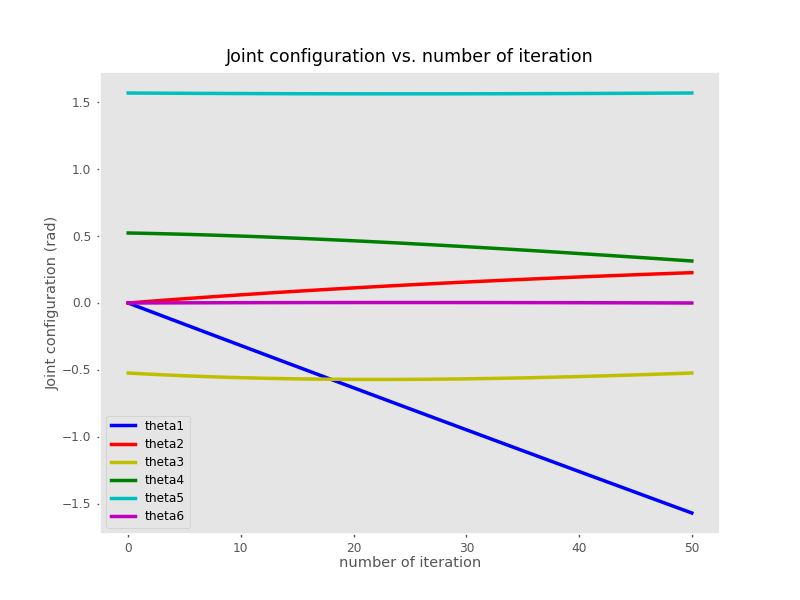

In [34]:
fig = plt.figure("No turning machine")
ax = plt.subplot(111)
ax.plot(list(range(51)),theta1,'-',linewidth=2,color='b',label='theta1')
ax.plot(list(range(51)),theta2,'-',linewidth=2,color='r',label='theta2')
ax.plot(list(range(51)),theta3,'-',linewidth=2,color='y',label='theta3')
ax.plot(list(range(51)),theta4,'-',linewidth=2,color='g',label='theta4')
ax.plot(list(range(51)),theta5,'-',linewidth=2,color='c',label='theta5')
ax.plot(list(range(51)),theta6,'-',linewidth=2,color='m',label='theta6')

plt.ylabel('Joint configuration (rad)')
plt.xlabel('number of iteration')
plt.title("Joint configuration vs. number of iteration")
ax.legend()
plt.grid()

# Polynomic Interpolation

In [36]:
import numpy as np
import math
from collections import namedtuple
import matplotlib.pyplot as plt
from spatialmath.base.argcheck import (
    isvector,
    getvector,
    assertmatrix,
    getvector,
    isscalar,
)
class Trajectory:

    def __init__(self, name, t, s, sd=None, sdd=None, istime=False):
        
        self.name = name
        self.t = t
        self.s = s
        self.sd = sd
        self.sdd = sdd
        self.istime = istime


    def __str__(self):
        s = f"Trajectory created by {self.name}: {len(self)} time steps x {self.naxes} axes"
        return s


    def __repr__(self):
        return str(self)


    def __len__(self):
        
        return self.s.shape[0]


    @property
    def q(self):
        
        return self.s

    @property
    def qd(self):
        
        return self.sd

    @property
    def qdd(self):
        
        return self.sdd

    

    @property
    def naxes(self):
        
        if self.s.ndim == 1:
            return 1
        else:
            return self.s.shape[1]

    def plot(self, block=False, plotargs=None, textargs=None):
        

        plotopts = {"marker": "o", "markersize": 3}
        if plotargs is not None:
            plotopts = {**plotopts, **plotargs}
        textopts = {"fontsize": 12}
        if textargs is not None:
            textopts = {**textopts, **textargs}

        plt.figure()
        ax = plt.subplot(3, 1, 1)

        # plot position
        if self.name == "tpoly":
            ax.plot(self.t, self.s, **plotopts)

        elif self.name == "lspb":
            # accel phase
            tf = self.t[-1]
            k = self.t <= self.tblend
            ax.plot(self.t[k], self.s[k], color="red", label="acceleration", **plotopts)

            # coast phase
            k = (self.t > self.tblend) & (self.t <= (tf - self.tblend))
            ax.plot(self.t[k], self.s[k], color="green", **plotopts)
            k = np.where(k)[0][0]
            ax.plot(
                self.t[k - 1 : k + 1], self.s[k - 1 : k + 1], color="green", label="linear", **plotopts
            )

            # decel phase
            k = self.t > (tf - self.tblend)
            ax.plot(self.t[k], self.s[k], color="blue", **plotopts)
            k = np.where(k)[0][0]
            ax.plot(
                self.t[k - 1 : k + 1], self.s[k - 1 : k + 1], color="blue", label="deceleration", **plotopts
            )

            ax.grid(True)
        else:
            ax.plot(self.t, self.s, **plotopts)

        if self.s.ndim > 1:
            ax.legend([f"q{i+1}" for i in range(self.naxes)])

        ax.grid(True)
        ax.set_xlim(0, max(self.t))

        if self.istime:
            if self.name in ("traj", "mtraj", "mstraj"):
                symbol = "q"
            else:
                symbol = "s"
            ax.set_ylabel(f"${symbol}(t)$", **textopts)
        else:
            ax.set_ylabel("$s(k)$", **textopts)

        # plot velocity
        ax = plt.subplot(3, 1, 2)
        ax.plot(self.t, self.sd, "-o", **plotopts)
        ax.grid(True)
        ax.set_xlim(0, max(self.t))

        if self.istime:
            ax.set_ylabel(f"$\dot{{{symbol}}}(t)$", **textopts)
        else:
            ax.set_ylabel("$ds/dk$", **textopts)

        # plot acceleration
        ax = plt.subplot(3, 1, 3)
        ax.plot(self.t, self.sdd, "-o", **plotopts)
        ax.grid(True)
        ax.set_xlim(0, max(self.t))

        if self.istime:
            ax.set_ylabel(f"$\ddot{{{symbol}}}(t)$", **textopts)
            ax.set_xlabel("t (seconds)")
        else:
            ax.set_ylabel("$d^2s/dk^2$", **textopts)
            ax.set_xlabel("k (step)")

        plt.show(block=block)
        
def tpoly(q0, qf, t, qd0=0, qdf=0):
    
    if isinstance(t, int):
        t = np.arange(0, t)
        istime = False
    elif isvector(t):
        t = getvector(t)
        istime = True
    else:
        raise TypeError("bad argument for time, must be int or vector")
    tf = max(t)

    polyfunc = tpoly_func(q0, qf, tf, qd0, qdf)

    # evaluate the polynomials
    traj = polyfunc(t)
    p = traj[0]
    pd = traj[1]
    pdd = traj[2]

    return Trajectory("tpoly", t, p, pd, pdd, istime)

def tpoly_func(q0, qf, T, qd0=0, qdf=0):

    # solve for the polynomial coefficients using least squares
    X = [
        [0, 0, 0, 0, 0, 1],
        [T ** 5, T ** 4, T ** 3, T ** 2, T, 1],
        [0, 0, 0, 0, 1, 0],
        [5 * T ** 4, 4 * T ** 3, 3 * T ** 2, 2 * T, 1, 0],
        [0, 0, 0, 2, 0, 0],
        [20 * T ** 3, 12 * T ** 2, 6 * T, 2, 0, 0],
    ]
    coeffs, resid, rank, s = np.linalg.lstsq(
        X, np.r_[q0, qf, qd0, qdf, 0, 0], rcond=None
    )

    # coefficients of derivatives
    coeffs_d = coeffs[0:5] * np.arange(5, 0, -1)
    coeffs_dd = coeffs_d[0:4] * np.arange(4, 0, -1)

    return lambda x: (
        np.polyval(coeffs, x),
        np.polyval(coeffs_d, x),
        np.polyval(coeffs_dd, x),
    )

def mtraj(tfunc, q0, qf, t):
    
    if not callable(tfunc):
        raise TypeError("first argument must be a function reference")

    q0 = getvector(q0)
    qf = getvector(qf)
    if len(q0) != len(qf):
        raise ValueError("must be same number of elements in q0 and qf")

    traj = []
    for i in range(len(q0)):
        # for each axis
        traj.append(tfunc(q0[i], qf[i], t))

    x = traj[0].t
    y = np.array([tg.s for tg in traj]).T
    yd = np.array([tg.sd for tg in traj]).T
    ydd = np.array([tg.sdd for tg in traj]).T

    istime = traj[0].istime

    return Trajectory("mtraj", x, y, yd, ydd, istime)

In [37]:
init_c= [-1.19450755, -0.1639    ,  0.3176  ,1.57079633e+00, -1.22464680e-16, -1.57079633e+00] 
con_c = [-0.89180313, -0.07524415,  0.29981583, 1.56497856e+00, -1.22107410e-16, -1.67079633e+00]
round_c = [-0.1639    ,  0.87983595,  0.29981583,1.56497856e+00, -1.22107410e-16, -3.14159265e+00 ]
end_c = [-0.1639    ,  1.23377441,  0.03966279,1.58824962e+00, -1.23524006e-16, -3.14159265e+00]

def pol_int(init_c,end_c):
    tg = mtraj(tpoly, init_c, end_c, 50)
    
    theta1=[]
    theta2=[]
    theta3=[]
    theta4=[]
    theta5=[]
    theta6=[]

    for i in tg.q:
        A=SE3.RPY([ i[3], i[4], i[5]])
        HT = np.vstack((np.hstack((A.R,np.array([[i[0]],[i[1]],[i[2]]]))),np.array([0,0,0,1])))
        print(HT)
        SE3(HT).plot()

        conf8_= invKine(HT) #8 solutions for the same HTM
        current_conf=np.array(conf8_[:,1]) #One solution chosen
        cconf_list=[current_conf[0][0] % -pi, current_conf[1][0],current_conf[2][0],current_conf[3][0],current_conf[4][0],current_conf[5][0]] 
        deg_list = np.degrees(cconf_list) #current config in degs
        
        theta1.append(cconf_list[0])
        theta2.append(cconf_list[1])
        theta3.append(cconf_list[2])
        theta4.append(cconf_list[3])
        theta5.append(cconf_list[4])
        theta6.append(cconf_list[5])
        
        print(cconf_list)
        robot.MoveJ([deg_list[0],deg_list[1],deg_list[2],deg_list[3],deg_list[4],deg_list[5]])                 # move the robot to the target
        
        
        
        
        import time
        time.sleep(0.1)
    
    return theta1, theta2,theta3, theta4,theta5, theta6

[[-3.20511012e-09 -3.20510434e-09 -1.00000000e+00 -1.19450755e+00]
 [-1.00000000e+00  1.32737392e-16  3.20511012e-09 -1.63900000e-01]
 [ 1.22464680e-16  1.00000000e+00 -3.20510434e-09  3.17600000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


<IPython.core.display.Javascript object>


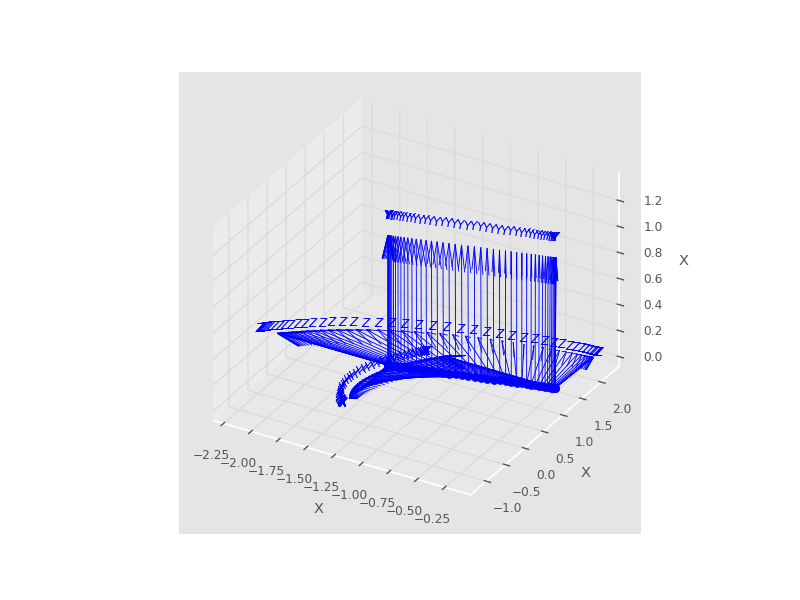

[-3.719453602180067e-05, -0.017946791991955202, -0.5236371301269463, 0.5415839253240058, 1.5707591354639818, -1.19140863937125e-13]
[[-1.29464845e-04 -1.44166756e-06 -9.99999992e-01 -1.19442261e+00]
 [-9.99999992e-01  1.86645392e-10  1.29464845e-04 -1.63784807e-01]
 [ 1.22464767e-16  1.00000000e+00 -1.44166757e-06  3.17577093e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.00013087923411614355, -0.017628274242448227, -0.5243066793667127, 0.5419363952767355, 1.5707949124063525, -2.0390168672708823e-12]
[[-1.00379925e-03 -1.11564892e-05 -9.99999496e-01 -1.19384895e+00]
 [-9.99999496e-01  1.11988812e-08  1.00379925e-03 -1.63006835e-01]
 [ 1.22465357e-16  1.00000000e+00 -1.11564948e-05  3.17422388e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.0007640023107535754, -0.01548828381470585, -0.5288054618258847, 0.5443049021357129, 1.5710361239026018, 2.675295298224489e-09]
[[-3.28195917e-03 -3.64692464e-05 -9.99994614e-01 -1.19235424e+0

[[-5.94119436e-01 -5.68574114e-03 -8.04356742e-01 -7.77112820e-01]
 [-8.04376837e-01  4.19953579e-03  5.94104593e-01  4.02156336e-01]
 [ 1.22893706e-16  9.99975018e-01 -7.06850431e-03  2.05035788e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.6696114524153769, 0.5542070040650282, -1.678371288022576, 1.1312368012226186, 1.5373561996454195, -0.00023646573892109263]
[[-6.40740760e-01 -5.93268232e-03 -7.67734382e-01 -7.38210886e-01]
 [-7.67757304e-01  4.95118882e-03  6.40721630e-01  4.54913796e-01]
 [ 1.22933692e-16  9.99970144e-01 -7.72728868e-03  1.94544603e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.7481919205120615, 0.5755329414005347, -1.7021014202606715, 1.1343065989329064, 1.5180686961820822, -0.0004078318209474894]
[[-6.85545710e-01 -6.11014457e-03 -7.28003946e-01 -6.98916557e-01]
 [-7.28029587e-01  5.75358952e-03  6.85521566e-01  5.08203410e-01]
 [ 1.22974081e-16  9.99964781e-01 -8.39271464e-03  1.83947595e-01]
 [ 0.00

[[-9.99716751e-01 -4.09065814e-04 -2.37960086e-02 -1.79516463e-01]
 [-2.37995244e-02  1.71831143e-02  9.99569069e-01  1.21259590e+00]
 [ 1.23507954e-16  9.99852276e-01 -1.71879827e-02  4.38742826e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5588642136299882, 0.27693421993853956, -0.6361148271202778, 0.3763706470236738, 1.558928421780647, -0.0002040250648979854]
[[-9.99898624e-01 -2.46247490e-04 -1.42365885e-02 -1.73242410e-01]
 [-1.42387180e-02  1.72924645e-02  9.99749083e-01  1.22110456e+00]
 [ 1.23514403e-16  9.99850444e-01 -1.72942177e-02  4.21822779e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.563723630739851, 0.2581648064564272, -0.5936321053923239, 0.35276282292709504, 1.5636308954594917, -0.00012394118707491044]
[[-9.99971628e-01 -1.30834475e-04 -7.53162734e-03 -1.68842329e-01]
 [-7.53276364e-03  1.73682289e-02  9.99820785e-01  1.22707179e+00]
 [ 1.23518926e-16  9.99849152e-01 -1.73687217e-02  4.09956516e-02]
 [ 0.0

In [38]:
theta1, theta2,theta3, theta4,theta5, theta6=pol_int(init_c, end_c)

<IPython.core.display.Javascript object>


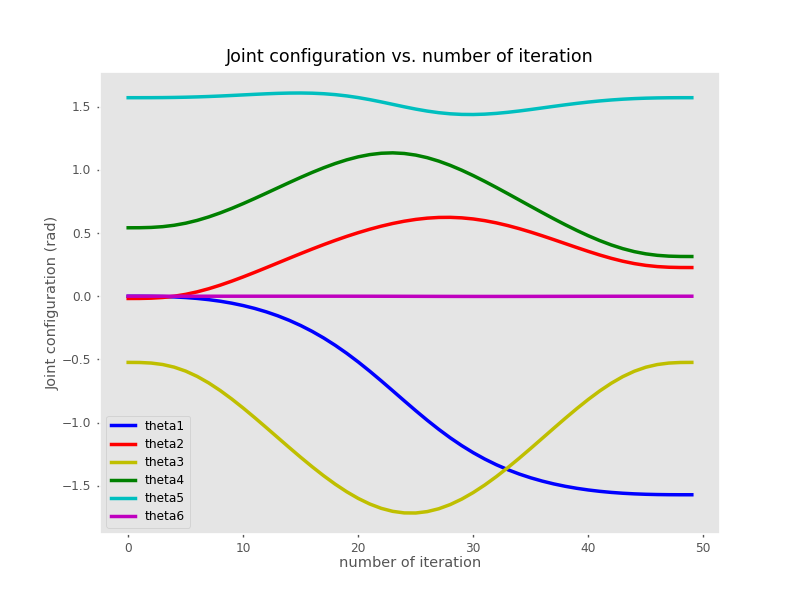

In [40]:
fig = plt.figure("No turning machine - QPI")
ax = plt.subplot(111)
ax.plot(list(range(50)),theta1,'-',linewidth=2,color='b',label='theta1')
ax.plot(list(range(50)),theta2,'-',linewidth=2,color='r',label='theta2')
ax.plot(list(range(50)),theta3,'-',linewidth=2,color='y',label='theta3')
ax.plot(list(range(50)),theta4,'-',linewidth=2,color='g',label='theta4')
ax.plot(list(range(50)),theta5,'-',linewidth=2,color='c',label='theta5')
ax.plot(list(range(50)),theta6,'-',linewidth=2,color='m',label='theta6')

plt.ylabel('Joint configuration (rad)')
plt.xlabel('number of iteration')
plt.title("Joint configuration vs. number of iteration")
ax.legend()
plt.grid()

[[-3.20510434e-09 -3.20510390e-09 -1.00000000e+00 -1.19450755e+00]
 [-1.00000000e+00  1.32737372e-16  3.20510434e-09 -1.63900000e-01]
 [ 1.22464680e-16  1.00000000e+00 -3.20510390e-09  3.17600000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


<IPython.core.display.Javascript object>


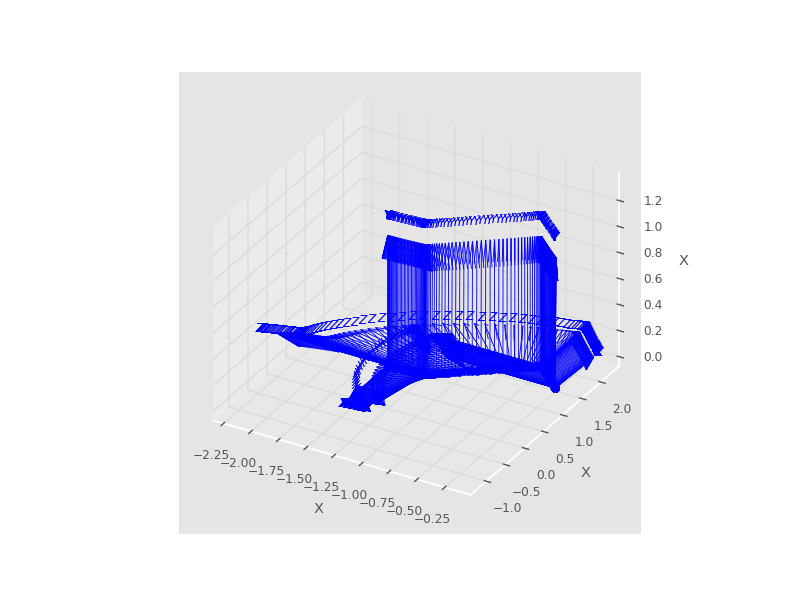

[-3.719453601824796e-05, -0.017946791991967526, -0.5236371301269204, 0.5415839253239917, 1.57075913546398, -1.1914084742797299e-13]
[[-8.24498915e-06  4.76282936e-07 -1.00000000e+00 -1.19448260e+00]
 [-1.00000000e+00 -3.92682517e-12  8.24498915e-06 -1.63892693e-01]
 [ 1.22464651e-16  1.00000000e+00  4.76282936e-07  3.17598534e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-4.3134844104786296e-05, -0.017871521537533408, -0.5238032435781543, 0.5416742888327519, 1.5707614369399379, 1.661750378039801e-11]
[[-6.39068570e-05  3.71456238e-06 -9.99999998e-01 -1.19431411e+00]
 [-9.99999998e-01 -2.37385885e-10  6.39068570e-05 -1.63843346e-01]
 [ 1.22464452e-16  1.00000000e+00  3.71456239e-06  3.17588635e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-8.326059954066878e-05, -0.01736383297925609, -0.524923761358033, 0.5422838797748994, 1.570776973052425, 7.189074512012823e-11]
[[-2.08939385e-04  1.21522211e-05 -9.99999978e-01 -1.19387509e+00]
 

[[-4.04888037e-02  2.35425188e-03 -9.99177219e-01 -1.07191265e+00]
 [-9.99179992e-01 -9.53990703e-05  4.04886913e-02 -1.27994495e-01]
 [ 1.22319986e-16  9.99997224e-01  2.35618397e-03  3.10397434e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.03295693371323183, 0.2173343269939102, -1.068887380109535, 0.8491967999344571, 1.57833924654283, -1.7772893006571334e-05]
[[-4.42600713e-02  2.57326020e-03 -9.99016729e-01 -1.06048659e+00]
 [-9.99020043e-01 -1.14004399e-04  4.42599245e-02 -1.24648038e-01]
 [ 1.22306500e-16  9.99996683e-01  2.57578436e-03  3.09726142e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.036458480796570436, 0.23258118956822688, -1.1067174821789476, 0.8715604267268134, 1.5786123547398405, -2.0132879267813753e-05]
[[-4.80687385e-02  2.79436573e-03 -9.98840121e-01 -1.04894527e+00]
 [-9.98844030e-01 -1.34477087e-04  4.80685504e-02 -1.21267826e-01]
 [ 1.22292879e-16  9.99996087e-01  2.79759967e-03  3.09048079e-01]
 [ 0

[[-9.83256082e-02  5.70181681e-03 -9.95137962e-01 -8.96389912e-01]
 [-9.95154297e-01 -5.63364503e-04  9.83239943e-02 -7.65875234e-02]
 [ 1.22112824e-16  9.99983586e-01  5.72958066e-03  3.00085308e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.0979628942064581, 0.3979328053728952, -1.5598051247334843, 1.156142706571577, 1.5713181596024581, -2.989932510549565e-06]
[[-9.89314123e-02  5.73671544e-03 -9.95077718e-01 -8.94547131e-01]
 [-9.95094255e-01 -5.70339300e-04  9.89297683e-02 -7.60478112e-02]
 [ 1.22110649e-16  9.99983382e-01  5.76499705e-03  2.99977043e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.09879931107051165, 0.3993446318393006, -1.5642365152551072, 1.1591268541866182, 1.5710905186902162, -1.6960436406908592e-06]
[[-9.93562492e-02  5.76118651e-03 -9.95035248e-01 -8.93254764e-01]
 [-9.95051926e-01 -5.75256293e-04  9.93545839e-02 -7.56693035e-02]
 [ 1.22109123e-16  9.99983239e-01  5.78983504e-03  2.99901115e-01]
 [ 0.0

[[-3.07749282e-01  5.53538473e-03 -9.51451385e-01 -7.86474373e-01]
 [-9.51467487e-01 -1.79040346e-03  3.07744074e-01  6.29574805e-02]
 [ 1.22107410e-16  9.99983077e-01  5.81773398e-03  2.99815830e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.28598574588696035, 0.45626888281705763, -1.7978057545980035, 1.3357170087527217, 1.5976367288223607, -0.00015619047076766032]
[[-3.44690406e-01  5.46120243e-03 -9.38700538e-01 -7.67132354e-01]
 [-9.38716424e-01 -2.00531709e-03  3.44684573e-01  8.83361011e-02]
 [ 1.22107410e-16  9.99983077e-01  5.81773398e-03  2.99815830e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.3253318386830655, 0.4624470165554263, -1.8316899486030094, 1.3634231100237741, 1.597372997930375, -0.00015465503356565052]
[[-3.83899397e-01  5.37194968e-03 -9.23359299e-01 -7.46293610e-01]
 [-9.23374926e-01 -2.23342456e-03  3.83892900e-01  1.15678572e-01]
 [ 1.22107410e-16  9.99983077e-01  5.81773398e-03  2.99815830e-01]
 [ 0

[[-9.77437775e-01  1.22884253e-03 -2.11219994e-01 -2.69228757e-01]
 [-2.11223568e-01 -5.68647295e-03  9.77421234e-01  7.41634320e-01]
 [ 1.22107410e-16  9.99983077e-01  5.81773398e-03  2.99815830e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.4419063129217724, 0.45699412843894, -1.8016143125884405, 1.3387818633824646, 1.486861161846319, 0.0004894707432827468]
[[-9.84384161e-01  1.02411658e-03 -1.76030607e-01 -2.51476076e-01]
 [-1.76033586e-01 -5.72688518e-03  9.84367502e-01  7.64927573e-01]
 [ 1.22107410e-16  9.99983077e-01  5.81773398e-03  2.99815830e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.4667290582869477, 0.45034808928808195, -1.7680527312018528, 1.3118713871138061, 1.497909178599831, 0.0004247977451176804]
[[-9.89586108e-01  8.37416974e-04 -1.43939686e-01 -2.35385866e-01]
 [-1.43942122e-01 -5.75714872e-03  9.89569361e-01  7.86039502e-01]
 [ 1.22107410e-16  9.99983077e-01  5.81773398e-03  2.99815830e-01]
 [ 0.0000000

[-1.5708480298557017, 0.403800807605243, -1.561821239017879, 1.1525552834488793, 1.570744620916479, 2.825830894425266e-07]
[[-1.00000000e+00  1.89411286e-11 -3.58973551e-09 -1.63900000e-01]
 [-3.58978548e-09 -5.27636167e-03  9.99986080e-01  8.88070015e-01]
 [ 1.22140366e-16  9.99986080e-01  5.27636167e-03  2.93763599e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5708478433510802, 0.40501964804524304, -1.5569540359439544, 1.1466580017394052, 1.5707448073660877, 2.718389237103851e-07]
[[-1.00000000e+00  1.80812309e-11 -3.58973639e-09 -1.63900000e-01]
 [-3.58978193e-09 -5.03682650e-03  9.99987315e-01  8.91713246e-01]
 [ 1.22154947e-16  9.99987315e-01  5.03682650e-03  2.91085740e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5708476086050949, 0.406516439137523, -1.5507246650073512, 1.1391713780623103, 1.5707450420454652, 2.5831566215586697e-07]
[[-1.00000000e+00  1.70295600e-11 -3.58973665e-09 -1.63900000e-01]
 [-3.58977704e-09 -

[[-1.00000000e+00 -3.19149706e-11 -3.58898455e-09 -1.63900000e-01]
 [-3.58912645e-09  8.89216192e-03  9.99960464e-01  1.10356667e+00]
 [ 1.23002865e-16  9.99960464e-01 -8.89216192e-03  1.35368523e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5708368663133827, 0.39108779486783785, -1.066638463115898, 0.6844429473607332, 1.5707557852901985, -3.605158776273587e-07]
[[-1.00000000e+00 -3.49412861e-11 -3.58888975e-09 -1.63900000e-01]
 [-3.58905984e-09  9.73553262e-03  9.99952609e-01  1.11639437e+00]
 [ 1.23054207e-16  9.99952609e-01 -9.73553262e-03  1.25939860e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5708363585391867, 0.3826346207996051, -1.0269045563457169, 0.6540056219654575, 1.570756293358875, -3.897652937313602e-07]
[[-1.00000000e+00 -3.78749359e-11 -3.58879248e-09 -1.63900000e-01]
 [-3.58899234e-09  1.05531178e-02  9.99944314e-01  1.12882998e+00]
 [ 1.23103979e-16  9.99944314e-01 -1.05531178e-02  1.16799398e-01]
 [ 0.000

[[-1.00000000e+00 -6.26415007e-11 -3.58873611e-09 -1.63900000e-01]
 [-3.58928277e-09  1.74524071e-02  9.99847695e-01  1.23377441e+00]
 [ 1.23524006e-16  9.99847695e-01 -1.74524071e-02  3.96627900e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-1.5708322420465626, 0.2269111876816941, -0.5236371902160266, 0.314179295750951, 1.5707604134245678, -6.26870235820557e-07]


In [41]:
import time 
theta1, theta2,theta3, theta4,theta5, theta6 = pol_int(init_c, con_c)
theta11, theta21,theta31, theta41,theta51, theta61=pol_int(con_c, round_c)
theta12, theta22,theta32, theta42,theta52, theta62=pol_int(round_c, end_c)

In [42]:
theta1 = np.hstack((np.hstack((np.array(theta1),np.array(theta11))),theta12))
theta2 = np.hstack((np.hstack((np.array(theta2),np.array(theta21))),theta22))
theta3 = np.hstack((np.hstack((np.array(theta3),np.array(theta31))),theta32))
theta4 = np.hstack((np.hstack((np.array(theta4),np.array(theta41))),theta42))
theta5 = np.hstack((np.hstack((np.array(theta5),np.array(theta51))),theta52))
theta6 = np.hstack((np.hstack((np.array(theta6),np.array(theta61))),theta62))

<IPython.core.display.Javascript object>


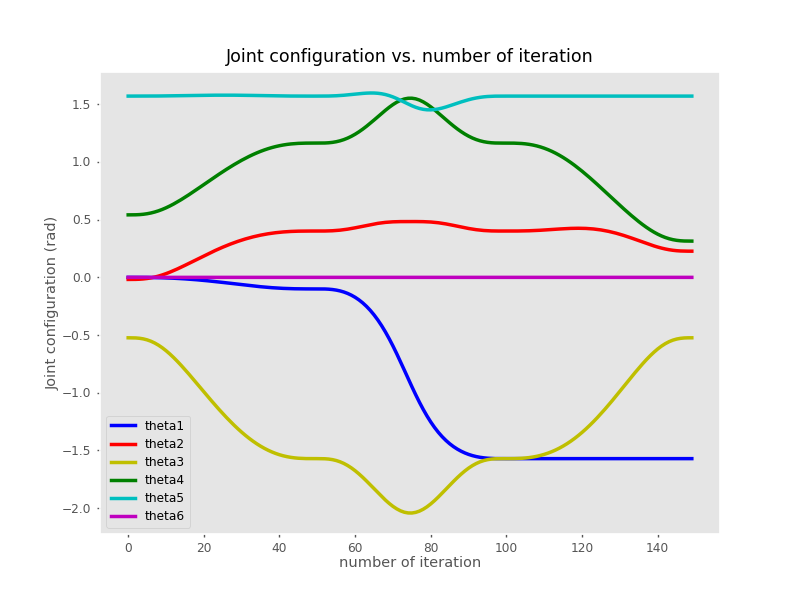

In [43]:
fig = plt.figure("With turning machine - QPI")
ax = plt.subplot(111)
ax.plot(list(range(150)),theta1,'-',linewidth=2,color='b',label='theta1')
ax.plot(list(range(150)),theta2,'-',linewidth=2,color='r',label='theta2')
ax.plot(list(range(150)),theta3,'-',linewidth=2,color='y',label='theta3')
ax.plot(list(range(150)),theta4,'-',linewidth=2,color='g',label='theta4')
ax.plot(list(range(150)),theta5,'-',linewidth=2,color='c',label='theta5')
ax.plot(list(range(150)),theta6,'-',linewidth=2,color='m',label='theta6')

plt.ylabel('Joint configuration (rad)')
plt.xlabel('number of iteration')
plt.title("Joint configuration vs. number of iteration")
ax.legend()
plt.grid()